In [1]:
import os
import numpy as np
import torch
import os
import re
import json
import argparse
import random
from torch.utils.data import DataLoader
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, T5ForConditionalGeneration
from model import T5ForConditionalGeneration, T5ForMultimodalGeneration
from utils_data import img_shape, load_data_std, load_data_img, ScienceQADatasetStd, ScienceQADatasetImg
from utils_prompt import *
# from utils_evaluate import get_scores
# from rich.table import Column, Table
# from rich import box
# from rich.console import Console
# console = Console(record=True)
from torch import cuda
import nltk
import evaluate
from omegaconf import OmegaConf
from datasets import load_dataset, DatasetDict
import matplotlib.pyplot as plt
from mypkg.common_utils import fix_seed,initialize_fixed_seed_dataLoader

#### 引数設定

In [2]:
# CUDA_VISIBLE_DEVICES=0,1 python main.py \
#     --model allenai/unifiedqa-t5-base \
#     --user_msg rationale --img_type detr \
#     --bs 8 --eval_bs 4 --eval_acc 10 --output_len 512 \
#     --final_eval --prompt_format QCM-LE \
#     --evaluate_dir models/MM-CoT-UnifiedQA-base-Rationale

In [3]:
args:dict = {}
args["img_type"] = "detr" #画像エンコーダーの種類
args["model"] = "/home/omote/WorkSpace/mm-cot/models/MM-CoT-UnifiedQA-base-Rationale"#"allenai/unifiedqa-t5-base" #使用するモデルの重みのリンク
args["evaluate_dir"] = "models/MM-CoT-UnifiedQA-base-Rationale"
args["data_root"] = "data" #
args["caption_file"] = "data/captions.json"
args["train_split"] = "train"
args["val_split"] = "val"
args["test_split"] = "test"
args["use_caption"] = False
args["input_len"] = 512 #入力のトーク数の最大長
args["output_len"] = 512#出力のトークン数の最大長
args["options"] = ["A", "B", "C", "D", "E"] #選択肢につける番号
args["prompt_format"] = "QCM-LE" #モデルの入出力形式：Input - Output
args["eval_bs"] = 8
args["seed"] = 42

args = OmegaConf.create(args)

In [4]:
fix_seed(args.seed)

In [5]:
fixed_dataloader:DataLoader = initialize_fixed_seed_dataLoader(args.seed)

#### デバイス

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### 使用するデータセットScienceQA

#### データ可視化

Found cached dataset parquet (/home/omote/.cache/huggingface/datasets/derek-thomas___parquet/derek-thomas--ScienceQA-ca4903a3b5795914/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

dict_keys(['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'])


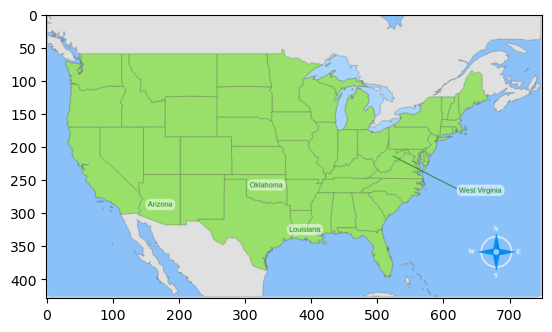

Question:
"Which of these states is farthest north?"
Context:
""
Options:
"['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma']"
Solution:
"Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.
A compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.
The north arrow points to the North Pole. On most maps, north is at the top of the map.To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north."
Answer:
"West Virginia"


In [7]:
ori_dataset = load_dataset("derek-thomas/ScienceQA")

sample = ori_dataset["train"][0]
print(sample.keys())
plt.imshow(sample["image"])
plt.show()
print(f'Question:\n"{sample["question"]}"\nContext:\n"{sample["hint"]}"\nOptions:\n"{sample["choices"]}"\nSolution:\n"{sample["lecture"]}{sample["solution"]}"\nAnswer:\n"{sample["choices"][sample["answer"]]}"')

#### データセット

In [8]:
from torch.utils.data import Dataset
class ScienceQADatasetImg(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, problems, qids, name_maps, tokenizer, source_len, target_len, args, image_features, test_le=None
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = {qid : problems[qid] for qid in qids}
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = []
        self.source_text = []
        self.image_ids = []
        if test_le is not None:
            test_le_data =json.load(open(test_le))["preds"]
        else:
            test_le_data = None
        idx = 0
        for qid in self.data:
            if test_le_data is not None:
                curr_le_data = test_le_data[idx]
                idx += 1
            else:
                curr_le_data = None
            prompt, target = build_train_pair(problems, qid, args, curr_le_data)
            self.target_text.append(target)
            self.source_text.append(prompt)
            if str(qid) in name_maps:
                i_vectors = image_features[int(name_maps[str(qid)])]
                self.image_ids.append(i_vectors)
            else:
                shape = img_shape[args.img_type]
                self.image_ids.append(np.zeros(shape))
    
    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])
        image_ids = self.image_ids[index]

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze().tolist()

        image_ids = torch.tensor(image_ids).squeeze()
        
        return {
            "input_ids": source_ids,
            "attention_mask": source_mask,
            "image_ids": image_ids,
            "labels": target_ids,
        }
    def get_raw_input(self,index):
        
        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])
        image_ids = self.image_ids[index]

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        # source = self.tokenizer.batch_encode_plus(
        #     [source_text],
        #     max_length=self.source_len,
        #     pad_to_max_length=True,
        #     truncation=True,
        #     padding="max_length",
        #     return_tensors="pt",
        # )
        # target = self.tokenizer.batch_encode_plus(
        #     [target_text],
        #     max_length=self.summ_len,
        #     pad_to_max_length=True,
        #     truncation=True,
        #     padding="max_length",
        #     return_tensors="pt",
        # )
        # source_ids = source["input_ids"].squeeze()
        # source_mask = source["attention_mask"].squeeze()
        # target_ids = target["input_ids"].squeeze().tolist()

        image_ids = torch.tensor(image_ids).squeeze()
        
        return {
            "input_text": source_text,
            "labels_text": target_text,
        }

In [9]:

problems, qids, name_maps, image_features = load_data_img(args)  # probelms, test question ids, shot example ids
dataframe = {'problems':problems, 'qids':qids, 'name_maps': name_maps, 'image_features': image_features}

#qidは問題番号train[1~max]valid[1~max]test[1~max]
#name maps は　問題番号：画像特徴のインデックス これはimage_featuresの画像がない場合は飛ばされているため

problems = dataframe['problems']
qids = dataframe['qids']
train_qids = qids['train']
test_qids = qids['test']
val_qids = qids['val']

#トークナイナー用意
tokenizer:T5Tokenizer = T5Tokenizer.from_pretrained(args.model)
print("特別トークン")
print(tokenizer.special_tokens_map)
print(f'vocab_size:{len(tokenizer.get_vocab())}')

img_features size:  (11208, 100, 256)
number of train problems: 12726

number of val problems: 4241

number of test problems: 4241

特別トークン
{'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id

In [10]:
text = "Hello World"

for i in range(5):
    print(tokenizer.tokenize(text))

['▁Hello', '▁World']
['▁Hello', '▁World']
['▁Hello', '▁World']
['▁Hello', '▁World']
['▁Hello', '▁World']


In [11]:
train_set = ScienceQADatasetImg(
    problems,
    train_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
)

valid_set = ScienceQADatasetImg(
    problems,
    val_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
)

test_set = ScienceQADatasetImg(
    problems,
    test_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
)
print(f'ori_size:{len(ori_dataset["train"])+len(ori_dataset["validation"])+len(ori_dataset["test"])}')
print(f'train_size:{len(train_set)}')
print(f'valid_size:{len(valid_set)}')
print(f'test_size:{len(test_set)}')
assert len(ori_dataset["train"])+len(ori_dataset["validation"])+len(ori_dataset["test"]) == len(train_set)+len(valid_set)+len(test_set),"データ数が違う"

ori_size:21208
train_size:12726
valid_size:4241
test_size:4241


In [12]:

datacollator = DataCollatorForSeq2Seq(tokenizer)
train_loader:DataLoader = fixed_dataloader(train_set,batch_size=args.eval_bs,collate_fn=datacollator,num_workers=4,pin_memory=True,drop_last=True)
valid_loader:DataLoader = fixed_dataloader(valid_set,batch_size=args.eval_bs,collate_fn=datacollator,num_workers=4,pin_memory=True,drop_last=True)
test_loader:DataLoader = fixed_dataloader(test_set,batch_size=args.eval_bs,collate_fn=datacollator,num_workers=4,pin_memory= True,drop_last = True)

In [13]:
print(train_set[0].keys())
print(train_set.get_raw_input(0))

dict_keys(['input_ids', 'attention_mask', 'image_ids', 'labels'])
{'input_text': 'Question: Which of these states is farthest north? Context: N/A Options: (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma Solution:', 'labels_text': 'Solution: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\\nThe north arrow points to the North Pole. On most maps, north is at the top of the map. To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north..'}


In [14]:
print(ori_dataset["validation"][0])

{'image': None, 'question': "What does the verbal irony in this text suggest?\nAccording to Mr. Herrera's kids, his snoring is as quiet as a jackhammer.", 'choices': ['The snoring is loud.', 'The snoring occurs in bursts.'], 'answer': 0, 'hint': '', 'task': 'closed choice', 'grade': 'grade8', 'subject': 'language science', 'topic': 'figurative-language', 'category': 'Literary devices', 'skill': 'Interpret figures of speech', 'lecture': 'Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.\nVerbal irony involves saying one thing but implying something very different. People often use verbal irony when they are being sarcastic.\nOlivia seems thrilled that her car keeps breaking down.\nEach breakdown is as enjoyable as a punch to the face.', 'solution': "The text uses verbal irony, which involves saying one thing but implying something very different.\nAs quiet as a jackhammer suggests that the snoring is loud. A j


train


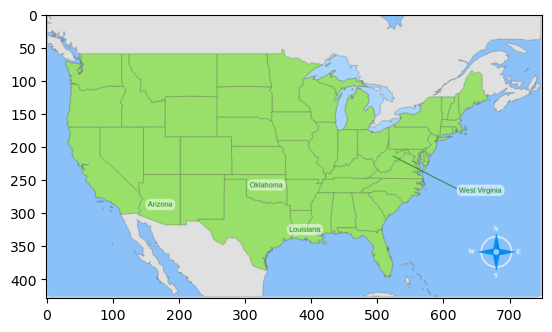

input:"Question: Which of these states is farthest north? Context: N/A Options: (A) West Virginia (B) Louisiana (C) Arizona (D) Oklahoma Solution:"
input_ids:"['▁Question', ':', '▁Which', '▁of', '▁these', '▁states', '▁is', '▁far', 'th', 'est', '▁north', '?', '▁Con', 'text', ':', '▁N', '/', 'A', '▁Options', ':', '▁(', 'A', ')', '▁West', '▁Virginia', '▁(', 'B', ')', '▁Louisiana', '▁(', 'C', ')', '▁Arizona', '▁(', 'D', ')', '▁Oklahoma', '▁Solution', ':', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

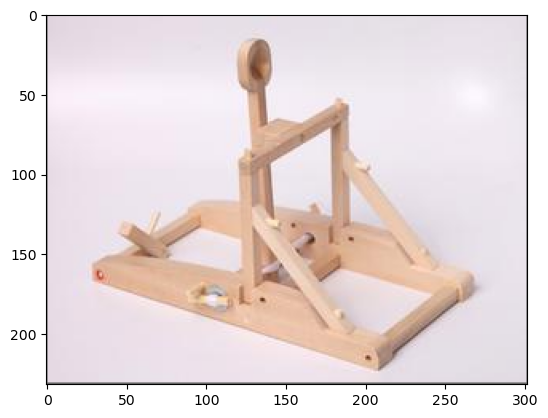

input:"Question: Identify the question that Tom and Justin's experiment can best answer. Context: The passage below describes an experiment. Read the passage and then follow the instructions below. Tom placed a ping pong ball in a catapult, pulled the catapult's arm back to a 45° angle, and launched the ball. Then, Tom launched another ping pong ball, this time pulling the catapult's arm back to a 30° angle. With each launch, his friend Justin measured the distance between the catapult and the place where the ball hit the ground. Tom and Justin repeated the launches with ping pong balls in four more identical catapults. They compared the distances the balls traveled when launched from a 45° angle to the distances the balls traveled when launched from a 30° angle. Figure: a catapult for launching ping pong balls. Options: (A) Do ping pong balls stop rolling along the ground sooner after being launched from a 30° angle or a 45° angle? (B) Do ping pong balls travel farther when launched f

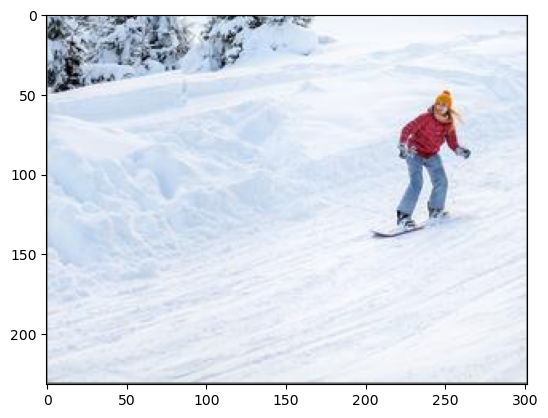

input:"Question: Identify the question that Kathleen and Bryant's experiment can best answer. Context: The passage below describes an experiment. Read the passage and then follow the instructions below. Kathleen applied a thin layer of wax to the underside of her snowboard and rode the board straight down a hill. Then, she removed the wax and rode the snowboard straight down the hill again. She repeated the rides four more times, alternating whether she rode with a thin layer of wax on the board or not. Her friend Bryant timed each ride. Kathleen and Bryant calculated the average time it took to slide straight down the hill on the snowboard with wax compared to the average time on the snowboard without wax. Figure: snowboarding down a hill. Options: (A) Does Kathleen's snowboard slide down a hill in less time when it has a layer of wax or when it does not have a layer of wax? (B) Does Kathleen's snowboard slide down a hill in less time when it has a thin layer of wax or a thick layer o

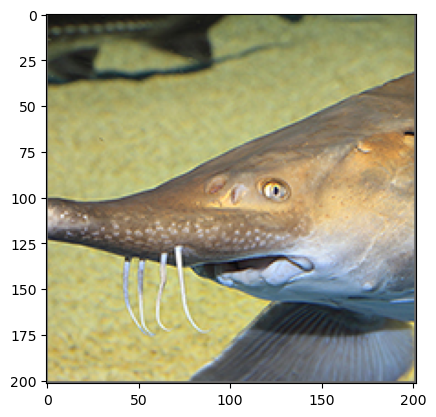

input:"Question: Which animal's mouth is also adapted for bottom feeding? Context: Sturgeons eat invertebrates, plants, and small fish. They are bottom feeders. Bottom feeders find their food at the bottom of rivers, lakes, and the ocean. The 's mouth is located on the underside of its head and points downward. Its mouth is adapted for bottom feeding. Figure: sturgeon. Options: (A) discus (B) armored catfish Solution:"
input_ids:"['▁Question', ':', '▁Which', '▁animal', "'", 's', '▁mouth', '▁is', '▁also', '▁', 'adapted', '▁for', '▁bottom', '▁feeding', '?', '▁Con', 'text', ':', '▁St', 'urgeon', 's', '▁', 'eat', '▁in', 'vert', 'e', 'bra', 'tes', ',', '▁plants', ',', '▁and', '▁small', '▁fish', '.', '▁They', '▁are', '▁bottom', '▁feeder', 's', '.', '▁Bottom', '▁feeder', 's', '▁find', '▁their', '▁food', '▁at', '▁the', '▁bottom', '▁of', '▁rivers', ',', '▁lakes', ',', '▁and', '▁the', '▁ocean', '.', '▁The', '▁', "'", 's', '▁mouth', '▁is', '▁located', '▁on', '▁the', '▁under', 'side', '▁of', '▁its

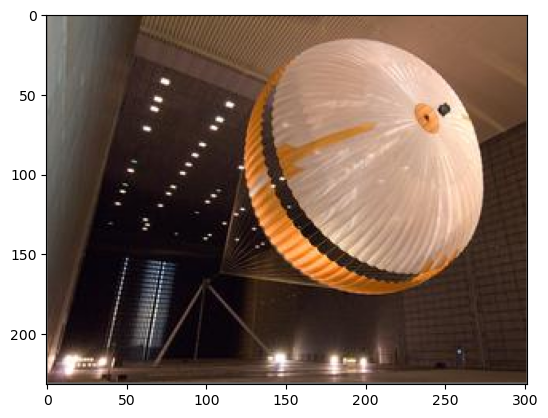

input:"Question: Which of the following could Gordon's test show? Context: People can use the engineering-design process to develop solutions to problems. One step in the process is testing if a potential solution meets the requirements of the design. The passage below describes how the engineering-design process was used to test a solution to a problem. Read the passage. Then answer the question below. Gordon was an aerospace engineer who was developing a parachute for a spacecraft that would land on Mars. He needed to add a vent at the center of the parachute so the spacecraft would land smoothly. However, the spacecraft would have to travel at a high speed before landing. If the vent was too big or too small, the parachute might swing wildly at this speed. The movement could damage the spacecraft. So, to help decide how big the vent should be, Gordon put a parachute with a 1 m vent in a wind tunnel. The wind tunnel made it seem like the parachute was moving at 200 km per hour. He ob

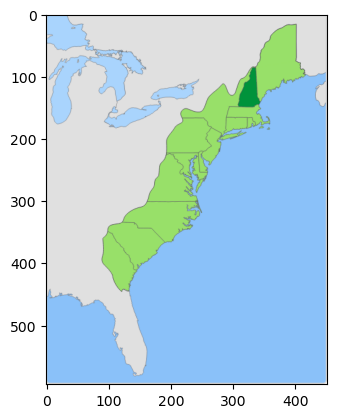

input:"Question: What is the name of the colony shown? Context: N/A Options: (A) Maryland (B) New Hampshire (C) Rhode Island (D) Vermont Solution:"
input_ids:"['▁Question', ':', '▁What', '▁is', '▁the', '▁name', '▁of', '▁the', '▁colon', 'y', '▁shown', '?', '▁Con', 'text', ':', '▁N', '/', 'A', '▁Options', ':', '▁(', 'A', ')', '▁Maryland', '▁(', 'B', ')', '▁New', '▁Hampshire', '▁(', 'C', ')', '▁Rhode', '▁Island', '▁(', 'D', ')', '▁Vermont', '▁Solution', ':', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [15]:
dataset_list = [train_set,valid_set,test_set]
dataset_list_name = ["train","validation","test"]
print()
for dataset, name in zip(dataset_list,dataset_list_name):
    print(name)
    for i in range(3):
        img = ori_dataset[name][i]["image"]
        if img is not None:
            plt.imshow(img)
            plt.show()
        else:
            print("image : None")

        sample = dataset[i]
        raw_sample = dataset.get_raw_input(i)
        print(f'input:"{raw_sample["input_text"]}"')
        print(f'input_ids:"{tokenizer.convert_ids_to_tokens(sample["input_ids"])}"')
        print(f'label:"{raw_sample["labels_text"]}')
        print(f'label:"{tokenizer.convert_ids_to_tokens(sample["labels"])}')
        print("\n")

    print("\n\n")

In [16]:
save_dir = "omote_experiment"#args["evaluate_dir"]

padding_idx:int = tokenizer._convert_token_to_id(tokenizer.pad_token)
patch_size = img_shape[args.img_type]
model:T5ForConditionalGeneration = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir) 
model = model.to(device)
print(model)

T5ForMultimodalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Drop

In [17]:
#モデルのメインインプット　trainer_seq2seqの196で判定される
print(model.encoder.main_input_name)
print(model.main_input_name)

input_ids
input_ids


In [18]:
# model2 = T5ForMultimodalGeneration.from_pretrained("allenai/unifiedqa-t5-base", patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir) 
# model2 = model2.to(device)
# #ちゃんとフォルダ指定しないと学習済みモデルロードされない
# for param,param2 in zip(model.parameters(), model2.parameters()):
#     print(param)
#     print(param2)
#     break

# for param,param2 in zip(model.gate_dense.parameters(),model2.gate_dense.parameters()):
#     print(param)
#     print(param2)
#     break

In [19]:
def convert_func(item):
    if isinstance(item,torch.Tensor) :
        item = item.to(torch.float32) if item.dtype == torch.float16 else item
        item = item.to(device).unsqueeze(dim=0)
    else:
        item = torch.tensor(item).to(device).unsqueeze(dim=0)
    return item

test_input = {
    k: convert_func(v) for (k, v) in train_set[0].items()
}


In [20]:
from torchinfo import summary
print(summary(model,input_data=test_input))

Layer (type:depth-idx)                                  Output Shape              Param #
T5ForMultimodalGeneration                               [1, 512, 768]             --
├─T5Stack: 1-1                                          [1, 512, 768]             109,628,544
├─T5Stack: 1-2                                          --                        (recursive)
│    └─Embedding: 2-1                                   [1, 512, 768]             24,674,304
├─T5Stack: 1-3                                          --                        (recursive)
│    └─Dropout: 2-2                                     [1, 512, 768]             --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─T5Block: 3-1                                [1, 512, 768]             7,079,808
│    │    └─T5Block: 3-2                                [1, 512, 768]             7,079,424
│    │    └─T5Block: 3-3                                [1, 512, 768]             7,079,424
│   

In [21]:



output = model(**test_input)
print("順伝播可能")
print(f'label:{train_set.get_raw_input(0)["labels_text"]}')
print(f'output:{tokenizer.batch_decode(output["logits"].argmax(dim=-1))}')

順伝播可能
label:Solution: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\nThe north arrow points to the North Pole. On most maps, north is at the top of the map. To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north..
output:['Solution: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.<unk> nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.<unk> nThe north arrow points to the North Pole. On most maps, north is at the top of the map. To find the answer, look at the compass rose. Look at which way the north arrow is pointing. Oklahoma Virginia is farthest n

In [22]:
print("推論可能")
generated = model.generate(test_input[model.main_input_name],attention_mask=test_input["attention_mask"],image_ids=test_input["image_ids"],labels=test_input["labels"],max_length=args.output_len)#print(model.generate(inputs=test_input[model.main_input_name],attention_mask=test_input["attention_mask"]))
for i, sample_output in enumerate(generated):
    print("{}: {}".format(i, tokenizer.decode(sample_output,skip_special_tokens=True)))


推論可能
0: Solution: Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.nThe north arrow points to the North Pole. On most maps, north is at the top of the map. To find the answer, look at the compass rose. Look at which way the north arrow is pointing. Oklahoma is farthest north..


In [23]:
use_loader = test_loader
use_set = test_set
use_qids = test_qids
use_name = "test"

In [24]:
test_input_batch = next(iter(use_loader))
test_input_labels = test_input_batch.pop("labels")
bos_token_id = tokenizer.bos_token_id
inputs = test_input_batch.pop("input_ids")
model_kwargs = test_input_batch
input_ids,model_input_name,model_kwargs = model._prepare_model_inputs(inputs,bos_token_id,model_kwargs)

input_ids = input_ids.to(device)
model_kwargs = {k:v.to(device) for k,v in model_kwargs.items()}
print(bos_token_id)
print(input_ids.shape)
print(model_input_name)
print(model_kwargs.keys())

None
torch.Size([8, 512])
input_ids
dict_keys(['attention_mask', 'image_ids'])


In [25]:
# output = model.generate(input_ids,**model_kwargs,max_length=512)
# print(output.shape)
# text_list = tokenizer.batch_decode(output,skip_special_tokens=True)
# for i,text in enumerate(text_list):
#     print(f'{i}："{text}"')
# for out in output:
#     print(tokenizer.batch_decode(out[-5:]))

In [26]:
output = model.generate(input_ids,**model_kwargs,max_length=512,num_beams=4,length_penalty=0.6,)
print(output.shape)
text_list = tokenizer.batch_decode(output,skip_special_tokens=True)
for i,text in enumerate(text_list):
    print(f'{i}："{text}"')

torch.Size([8, 466])
0："Solution: Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.nAnaphora is the repetition of the same word or words at the beginning of several phrases or clauses.nWe are united. We are powerful. We are winners.nAntithesis involves contrasting opposing ideas within a parallel grammatical structure.nI want to help, not to hurt.nApostrophe is a direct address to an absent person or a nonhuman entity.nOh, little bird, what makes you sing so beautifully?nAssonance is the repetition of a vowel sound in a series of nearby words.nTry to light the fire.nChiasmus is an expression in which the second half parallels the first but reverses the order of words.nNever let a fool kiss you or a kiss fool you.nA euphemism is a polite or indirect expression that is used to de-emphasize an unpleasant topic.nThe head of Human Resources would never refer to firing people, only to laying them off.nHyperbole is 

In [27]:
# output = model.generate(input_ids,**model_kwargs,max_length=512,num_beams=4,length_penalty=0.6,early_stopping=True)
# print(output.shape)
# text_list = tokenizer.batch_decode(output,skip_special_tokens=True)
# for i,text in enumerate(text_list):
#     print(f'{i}："{text}"')

In [28]:
for i in range(args.eval_bs):
    print(test_input_labels.shape)
    print(f'{i}：{test_set.get_raw_input(i)["labels_text"]}')

torch.Size([8, 512])
0：Solution: Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.\nAnaphora is the repetition of the same word or words at the beginning of several phrases or clauses.\nWe are united. We are powerful. We are winners.\nAntithesis involves contrasting opposing ideas within a parallel grammatical structure.\nI want to help, not to hurt.\nApostrophe is a direct address to an absent person or a nonhuman entity.\nOh, little bird, what makes you sing so beautifully?\nAssonance is the repetition of a vowel sound in a series of nearby words.\nTry to light the fire.\nChiasmus is an expression in which the second half parallels the first but reverses the order of words.\nNever let a fool kiss you or a kiss fool you.\nUnderstatement involves deliberately representing something as less serious or important than it really is.\nAs you know, it can get a little cold in the Antarctic. The text uses apostrophe

In [29]:
args.prompt_format = "QCMLE-A"
test_set_2 = ScienceQADatasetImg(
    problems,
    use_qids,
    name_maps,
    tokenizer,
    args.input_len,
    args.output_len,
    args,
    image_features,
)
id = 3
print(test_set_2.get_raw_input(id)["labels_text"])
print(ori_dataset[use_name][id]["choices"][ori_dataset[use_name][id]["answer"]])

The answer is (A).
no


In [30]:
test_input_batch = {"input_ids":[],"attention_mask":[],"image_ids":[],"labels":[]}
for i in range(args.eval_bs):
    raw_sample = use_set.get_raw_input(i)
    sample = use_set[i]
    raw_sample_2 = test_set_2.get_raw_input(i)
    input_text = f'{raw_sample["input_text"].removesuffix("Solution:")}{text_list[i]}\nAnswer:'
    label_text = raw_sample_2["labels_text"]
    input_text = " ".join(input_text.split()) #いらないだろう？ cleaning data so as to ensure data is in string type
    label_text = " ".join(label_text.split()) #いらないだろう？ cleaning data so as to ensure data is in string type
    print(input_text)
    print(label_text)
    test_input_batch["input_ids"].append(input_text)
    test_input_batch["labels"].append(label_text)
    test_input_batch["image_ids"].append(sample["image_ids"].to(torch.float32).to(device))

test_input_batch["input_ids"][5] ="Question: Which of these organisms contains matter that was once part of the lichen? Context: Below is a food web from a tundra ecosystem in Nunavut, a territory in Northern Canada. A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem. Options: (A) bilberry (B) mushroom Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eaten. The arrow points to the organism that is doing the eating.nAn organism in a food web can have more than one arrow pointing from it. This shows that the organism is eaten by more than one other organism in the food web.nAn organism in a food web can also have more than one arrow pointing to it. This shows that the organism eats more than one other organism in the food web. Use the arrows to follow how matter moves through this food web. For each answer choice, try to find a path of arrows that starts from the lichen.nThe bilberry does not have any arrows pointing to it. So, in this food web, matter does not move from the lichen to the bilberry.. Answer:" 


source = tokenizer.batch_encode_plus(
        test_input_batch["input_ids"],
        max_length=args.input_len,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

target = tokenizer.batch_encode_plus(
        test_input_batch["labels"],
        max_length=args.input_len,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
test_input_batch["input_ids"] = source["input_ids"].to(device)
test_input_batch["attention_mask"] = source["attention_mask"].to(device)
test_input_batch["image_ids"] = torch.stack(test_input_batch["image_ids"],dim=0)
test_input_batch["labels"] = target["input_ids"].to(device)
print(test_input_batch["input_ids"].shape)
print(test_input_batch["labels"].shape)

Question: Which figure of speech is used in this text? Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans. —Homer, The Iliad Context: N/A Options: (A) chiasmus (B) apostrophe Solution: Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.nAnaphora is the repetition of the same word or words at the beginning of several phrases or clauses.nWe are united. We are powerful. We are winners.nAntithesis involves contrasting opposing ideas within a parallel grammatical structure.nI want to help, not to hurt.nApostrophe is a direct address to an absent person or a nonhuman entity.nOh, little bird, what makes you sing so beautifully?nAssonance is the repetition of a vowel sound in a series of nearby words.nTry to light the fire.nChiasmus is an expression in which the second half parallels the first but reverses the order of words.nNever let a fool kiss you or a kiss fool you.

In [31]:
tmp = ["A", "B", "C", "D", "E"]
for i in range(args.eval_bs):
    print(tmp[int(ori_dataset[use_name][i]["answer"])])

B
B
B
A
B
B
A
B


In [32]:
args.model = "models/MM-CoT-UnifiedQA-base-Answer"

In [33]:
model:T5ForConditionalGeneration = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir) 
model = model.to(device)
print(model)

T5ForMultimodalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Drop

In [34]:
#順伝播可能
print(test_input_batch.keys())
output = model(**test_input_batch)
print(tokenizer.batch_decode(output["logits"].argmax(dim=-1)))

dict_keys(['input_ids', 'attention_mask', 'image_ids', 'labels'])
['The answer is (A).</s>', 'The answer is (B).</s>', 'The answer is (B).</s>', 'The answer is (A).</s>', 'The answer is (A).</s>', 'The answer is (B).</s>', 'The answer is (A).</s>', 'The answer is (A).</s>']


In [35]:
print(test_input_batch.keys())

dict_keys(['input_ids', 'attention_mask', 'image_ids', 'labels'])


In [36]:
input_ids = test_input_batch[model.main_input_name]
test_input_batch.pop("input_ids")
test_input_batch.pop("labels")
model_kwargs = test_input_batch
output = model.generate(input_ids,**model_kwargs,max_length=512,num_beams=4,length_penalty=0.6,)
print(output.shape)
answer_list = tokenizer.batch_decode(output,skip_special_tokens=True)
for i,text in enumerate(answer_list):
    print(f'{i}："{text}"')

torch.Size([8, 8])
0："The answer is (A)."
1："The answer is (B)."
2："The answer is (B)."
3："The answer is (A)."
4："The answer is (A)."
5："The answer is (B)."
6："The answer is (A)."
7："The answer is (A)."


In [37]:
def get_choice_text(probelm, options):
    choices = probelm['choices']
    choice_list = []
    for i, c in enumerate(choices):
        choice_list.append("({}) {}".format(options[i], c))
    choice_txt = " ".join(choice_list)
    # print(choice_txt)
    return choice_txt

image:None
Question:
"Which figure of speech is used in this text?
Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans.
—Homer, The Iliad"
Context:
""
Options:
"(A) chiasmus (B) apostrophe"
Solution:
"Solution: Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.nAnaphora is the repetition of the same word or words at the beginning of several phrases or clauses.nWe are united. We are powerful. We are winners.nAntithesis involves contrasting opposing ideas within a parallel grammatical structure.nI want to help, not to hurt.nApostrophe is a direct address to an absent person or a nonhuman entity.nOh, little bird, what makes you sing so beautifully?nAssonance is the repetition of a vowel sound in a series of nearby words.nTry to light the fire.nChiasmus is an expression in which the second half parallels the first but reverses the order of words.nNever let a fool kis

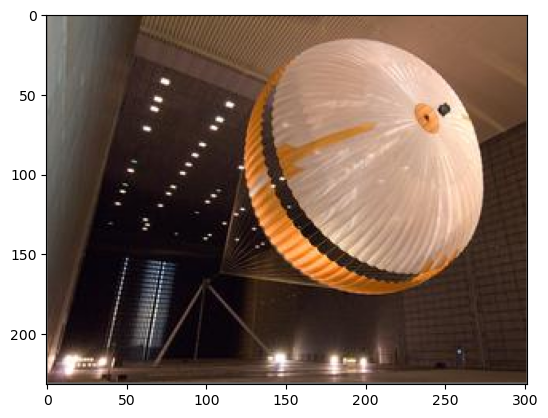

Question:
"Which of the following could Gordon's test show?"
Context:
"People can use the engineering-design process to develop solutions to problems. One step in the process is testing if a potential solution meets the requirements of the design.
The passage below describes how the engineering-design process was used to test a solution to a problem. Read the passage. Then answer the question below.

Gordon was an aerospace engineer who was developing a parachute for a spacecraft that would land on Mars. He needed to add a vent at the center of the parachute so the spacecraft would land smoothly. However, the spacecraft would have to travel at a high speed before landing. If the vent was too big or too small, the parachute might swing wildly at this speed. The movement could damage the spacecraft.
So, to help decide how big the vent should be, Gordon put a parachute with a 1 m vent in a wind tunnel. The wind tunnel made it seem like the parachute was moving at 200 km per hour. He obser

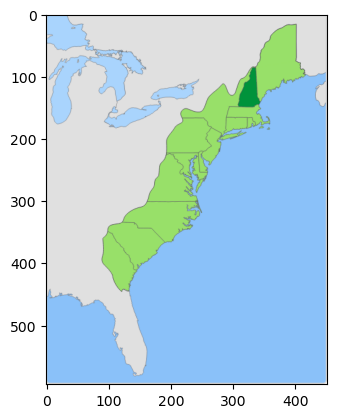

Question:
"What is the name of the colony shown?"
Context:
""
Options:
"(A) Maryland (B) New Hampshire (C) Rhode Island (D) Vermont"
Solution:
"Solution: The colony is New Hampshire.nDuring the colonial era, New Hampshire and New York both claimed the territory that would later become the state of Vermont. Vermont was never its own colony.."Answer:
"The answer is (B)."
GroundTruth:
"B"


image:None
Question:
"Would you find the word dozen on a dictionary page with the following guide words?
daddy - definition"
Context:
""
Options:
"(A) no (B) yes"
Solution:
"Solution: Guide words appear on each page of a dictionary. They tell you the first word and last word on the page. The other words on the page come between the guide words in alphabetical order.nTo put words in alphabetical order, put them in order by their first letters. If the first letters are the same, look at the second letters. If the second letters are the same, look at the third letters, and so on.nIf one word is shorter, a

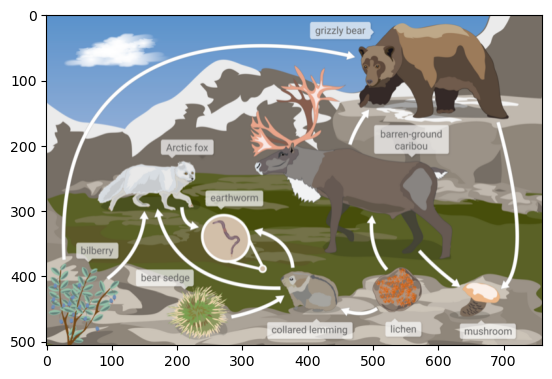

Question:
"Which of these organisms contains matter that was once part of the lichen?"
Context:
"Below is a food web from a tundra ecosystem in Nunavut, a territory in Northern Canada.
A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem."
Options:
"(A) bilberry (B) mushroom"
Solution:
"Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the org

In [38]:
for i in range(args.eval_bs):
    ori_sample = ori_dataset[use_name][i]
    img = ori_sample["image"]
    if img is not None:
        plt.imshow(img)
        plt.show()
    else:
        print("image:None")
    print(f'Question:\n"{ori_sample["question"]}"\nContext:\n"{ori_sample["hint"]}"\nOptions:\n"{get_choice_text(ori_sample,["A", "B", "C", "D", "E"])}"\nSolution:\n"{text_list[i]}"Answer:\n"{answer_list[i]}"')
    print(f'GroundTruth:\n"{tmp[int(ori_dataset[use_name][i]["answer"])]}"')
    print("\n")

In [39]:
print(tokenizer.batch_decode(input_ids,skip_special_tokens=True)[5])

Question: Which of these organisms contains matter that was once part of the lichen? Context: Below is a food web from a tundra ecosystem in Nunavut, a territory in Northern Canada. A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem. Options: (A) bilberry (B) mushroom Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eat

image:None
Question:
"Which figure of speech is used in this text?
Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans.
—Homer, The Iliad"
Context:
""
Options:
"(A) chiasmus (B) apostrophe"
Solution:
"Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.
Anaphora is the repetition of the same word or words at the beginning of several phrases or clauses.
We are united. We are powerful. We are winners.
Antithesis involves contrasting opposing ideas within a parallel grammatical structure.
I want to help, not to hurt.
Apostrophe is a direct address to an absent person or a nonhuman entity.
Oh, little bird, what makes you sing so beautifully?
Assonance is the repetition of a vowel sound in a series of nearby words.
Try to light the fire.
Chiasmus is an expression in which the second half parallels the first but reverses the order of words.
Never let a fool kiss you or a

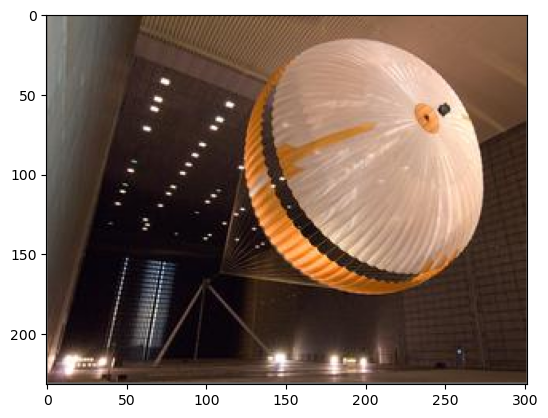

Question:
"Which of the following could Gordon's test show?"
Context:
"People can use the engineering-design process to develop solutions to problems. One step in the process is testing if a potential solution meets the requirements of the design.
The passage below describes how the engineering-design process was used to test a solution to a problem. Read the passage. Then answer the question below.

Gordon was an aerospace engineer who was developing a parachute for a spacecraft that would land on Mars. He needed to add a vent at the center of the parachute so the spacecraft would land smoothly. However, the spacecraft would have to travel at a high speed before landing. If the vent was too big or too small, the parachute might swing wildly at this speed. The movement could damage the spacecraft.
So, to help decide how big the vent should be, Gordon put a parachute with a 1 m vent in a wind tunnel. The wind tunnel made it seem like the parachute was moving at 200 km per hour. He obser

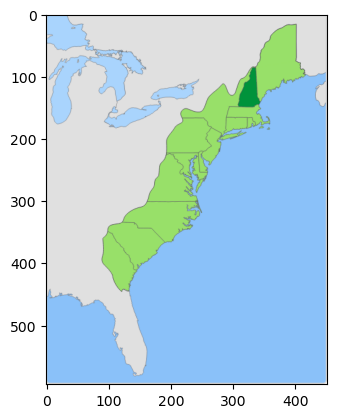

Question:
"What is the name of the colony shown?"
Context:
""
Options:
"(A) Maryland (B) New Hampshire (C) Rhode Island (D) Vermont"
Solution:
"The colony is New Hampshire.
During the colonial era, New Hampshire and New York both claimed the territory that would later become the state of Vermont. Vermont was never its own colony."
Answer:
"The answer is (B)"


image:None
Question:
"Would you find the word dozen on a dictionary page with the following guide words?
daddy - definition"
Context:
""
Options:
"(A) no (B) yes"
Solution:
"Guide words appear on each page of a dictionary. They tell you the first word and last word on the page. The other words on the page come between the guide words in alphabetical order.
To put words in alphabetical order, put them in order by their first letters. If the first letters are the same, look at the second letters. If the second letters are the same, look at the third letters, and so on.
If one word is shorter, and there are no more letters to compar

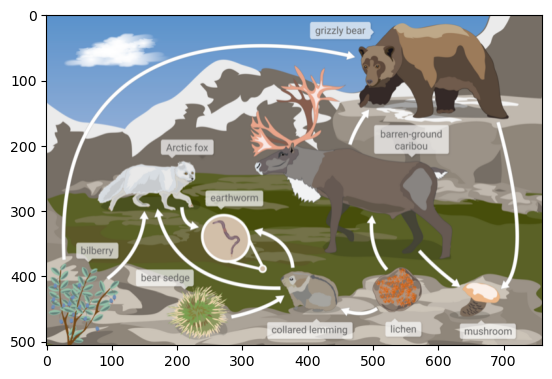

Question:
"Which of these organisms contains matter that was once part of the lichen?"
Context:
"Below is a food web from a tundra ecosystem in Nunavut, a territory in Northern Canada.
A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem."
Options:
"(A) bilberry (B) mushroom"
Solution:
"A food web is a model.
A food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.
Arrows show how matter moves.
A food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that

In [40]:
for i in range(args.eval_bs):
    ori_sample = ori_dataset[use_name][i]
    img = ori_sample["image"]
    if img is not None:
        plt.imshow(img)
        plt.show()
    else:
        print("image:None")
    print(f'Question:\n"{ori_sample["question"]}"\nContext:\n"{ori_sample["hint"]}"\nOptions:\n"{get_choice_text(ori_sample,tmp)}"\nSolution:\n"{ori_sample["lecture"]}{ori_sample["solution"]}"\nAnswer:\n"The answer is ({tmp[ori_sample["answer"]]})"')
    print("\n")

In [58]:
input_text ="""
Question:
"Which of these organisms contains matter that was once part of the Grasshopper?"
Context:
"Below is a food web from an ecosystem. A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem."
Options:
"(A) Fox (B) Hawk"
Solution:
"""

In [59]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import requests
image = Image.open("/home/omote/WorkSpace/mm-cot/stock-vector-food-chain-concept-diagram-illustration-1883719774.jpg")
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-101-dc5')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-101-dc5')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

In [60]:
print(outputs.last_hidden_state.shape)
image_ids = outputs.last_hidden_state
inputs = [" ".join(input_text.split())]
inputs = tokenizer.batch_encode_plus(
        inputs,
        max_length=args.input_len,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
test_input = {}
test_input["input_ids"] = inputs["input_ids"].to(device)
test_input["attention_mask"] = inputs["attention_mask"].to(device)
test_input["image_ids"] = image_ids.to(device)

torch.Size([1, 100, 256])


In [61]:
args.model = "/home/omote/WorkSpace/mm-cot/models/MM-CoT-UnifiedQA-base-Rationale"
model:T5ForConditionalGeneration = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir) 
model = model.to(device)

In [62]:
bos_token_id = tokenizer.bos_token_id
inputs = test_input.pop("input_ids")
model_kwargs = test_input
input_ids,model_input_name,model_kwargs = model._prepare_model_inputs(inputs,bos_token_id,model_kwargs)

input_ids = input_ids.to(device)
model_kwargs = {k:v.to(device) for k,v in model_kwargs.items()}
output = model.generate(input_ids,**model_kwargs,max_length=512,num_beams=4,length_penalty=0.6,)

In [63]:
out_text = tokenizer.batch_decode(output,skip_special_tokens=True)
print(out_text)

['Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eaten. The arrow points to the organism that is doing the eating.nAn organism in a food web can have more than one arrow pointing from it. This shows that the organism is eaten by more than one other organism in the food web.nAn organism in a food web can also have more than one arrow pointing to it. This shows that the organism eats more than one other organism in the food web. Use

In [69]:
print(outputs.last_hidden_state.shape)
image_ids = outputs.last_hidden_state
input_text = 'Question: "Which of these organisms contains matter that was once part of the Grasshopper?" Context: "Below is a food web from an ecosystem. A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem." Options: "(A) Hawk (B) Fox" Solution: Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eaten. The arrow points to the organism that is doing the eating.nAn organism in a food web can have more than one arrow pointing from it. This shows that the organism is eaten by more than one other organism in the food web.nAn organism in a food web can also have more than one arrow pointing to it. This shows that the organism eats more than one other organism in the food web. Use the arrows to follow how matter moves through this food web. For each answer choice, try to find a path of arrows that starts from the Grasshopper.nThe Hawk has an arrow pointing to it from the Grasshopper. So, in this food web, matter does not move from the Grasshopper to the Fox.. Answer:'#input_text.removesuffix("Solution:") + out_text[0]+"\nAnswer: \n"
input_text = [" ".join(input_text.split())]
inputs = tokenizer.batch_encode_plus(
        input_text,
        max_length=args.input_len,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
test_input = {}
test_input["input_ids"] = inputs["input_ids"].to(device)
test_input["attention_mask"] = inputs["attention_mask"].to(device)
test_input["image_ids"] = image_ids.to(device)
print(input_text)

torch.Size([1, 100, 256])
['Question: "Which of these organisms contains matter that was once part of the Grasshopper?" Context: "Below is a food web from an ecosystem. A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem." Options: "(A) Hawk (B) Fox" Solution: Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eaten. The a

In [70]:
args.model = "/home/omote/WorkSpace/mm-cot/models/MM-CoT-UnifiedQA-base-Answer"
model:T5ForConditionalGeneration = T5ForMultimodalGeneration.from_pretrained(args.model, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir) 
model = model.to(device)

In [71]:
bos_token_id = tokenizer.bos_token_id
inputs = test_input.pop("input_ids")
model_kwargs = test_input
input_ids,model_input_name,model_kwargs = model._prepare_model_inputs(inputs,bos_token_id,model_kwargs)

input_ids = input_ids.to(device)
model_kwargs = {k:v.to(device) for k,v in model_kwargs.items()}
output = model.generate(input_ids,**model_kwargs,max_length=512,num_beams=4,length_penalty=0.6,)

In [72]:
out_text = tokenizer.batch_decode(output,skip_special_tokens=True)
print(out_text)

['The answer is (A).']


In [73]:
print(tokenizer.batch_decode(input_ids))

['Question: "Which of these organisms contains matter that was once part of the Grasshopper?" Context: "Below is a food web from an ecosystem. A food web models how the matter eaten by organisms moves through an ecosystem. The arrows in a food web represent how matter moves between organisms in an ecosystem." Options: "(A) Hawk (B) Fox" Solution: Solution: A food web is a model.nA food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.nArrows show how matter moves.nA food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eaten. The arrow points to the organis

In [68]:
print(ori_dataset["test"][5]["lecture"])

A food web is a model.
A food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecosystem, the food web would be hard to understand. So, each food web shows how some organisms in an ecosystem can get their food.
Arrows show how matter moves.
A food web has arrows that point from one organism to another. Each arrow shows the direction that matter moves when one organism eats another organism. An arrow starts from the organism that is eaten. The arrow points to the organism that is doing the eating.
An organism in a food web can have more than one arrow pointing from it. This shows that the organism is eaten by more than one other organism in the food web.
An organism in a food web can also have more than one arrow pointing to it. This shows that the organism eats more than one other organism in the food web.


In [52]:
print(ori_dataset["test"][5]["solution"])

Use the arrows to follow how matter moves through this food web. For each answer choice, try to find a path of arrows that starts from the lichen.
No arrow points to the bilberry. So, in this food web, matter does not move from the lichen to the bilberry.


In [53]:
# training_args = Seq2SeqTrainingArguments(
#             save_dir,
#             do_train=True if args.evaluate_dir is None else False,
#             do_eval=False,
#             evaluation_strategy="no",
#             logging_strategy="steps",
#             save_strategy="epoch",
#             save_total_limit=2,
#             learning_rate=5e-5,
#             eval_accumulation_steps=10,
#             per_device_train_batch_size=8,
#             per_device_eval_batch_size=2,
#             weight_decay=0.01,
#             num_train_epochs=2,
#             predict_with_generate=True,
#             report_to="none",
#         )

# datacollator = DataCollatorForSeq2Seq(tokenizer)

# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_set,
#     eval_dataset=train_set,
#     data_collator=datacollator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics_rougel,
# )

# # if args.evaluate_dir is None:
# #     trainer.train()
# #     trainer.save_model(save_dir)
# print("評価")
# # metrics = trainer.evaluate(eval_dataset=test_set)
# print("評価終わり")
# # trainer.log_metrics("test", metrics)
# # trainer.save_metrics("test", metrics)

# predict_results = trainer.predict(test_dataset=train_set, max_length=args.output_len)

In [54]:
x = torch.tensor([
    [[1,2],[3,4]],
    [[5,6],[7,8]],
    [[9,10],[10,11]]
    ])

In [55]:
print(x.shape)

torch.Size([3, 2, 2])


In [56]:
z = []
for ten in x:
    for _ in range(4):
        z.append(ten)
print(z)
z = torch.stack(z,dim=0)

[tensor([[1, 2],
        [3, 4]]), tensor([[1, 2],
        [3, 4]]), tensor([[1, 2],
        [3, 4]]), tensor([[1, 2],
        [3, 4]]), tensor([[5, 6],
        [7, 8]]), tensor([[5, 6],
        [7, 8]]), tensor([[5, 6],
        [7, 8]]), tensor([[5, 6],
        [7, 8]]), tensor([[ 9, 10],
        [10, 11]]), tensor([[ 9, 10],
        [10, 11]]), tensor([[ 9, 10],
        [10, 11]]), tensor([[ 9, 10],
        [10, 11]])]


In [57]:
print(z.shape)

torch.Size([12, 2, 2])
